# Convolutional Neural Networks
This notebook will guide you through the use of the `keras` package to train convolutional neural networks for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998.

## Loading the packages

In [1]:
%pip install tensorflow --upgrade
%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from scipy import stats

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.1 MB 393.8 kB/s eta 0:00:03
   ---------- ----------------------------- 0.3/1.1 MB 2.0 MB/s eta 0:00:01
   ---------------------------------------  1.1/1.1 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 5.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
Note: you may need to restart the kernel to use updated packages.


First, create some useful functions

In [2]:
def build_grid_of_images(array):
    assert len(array.shape) == 3
    dim_0 = np.sqrt(array.shape[0])
    assert dim_0.is_integer()

    temp_out = np.reshape(array, (dim_0, dim_0, array.shape[1], array.shape[2]))
    temp_out = np.rollaxis(temp_out, 1, 3)
    return np.reshape(temp_out, (dim_0*array.shape[1], dim_0*array.shape[2]))

def plot_conv_layer_output(temp_out, title):
    temp_to_plot = build_grid_of_images(temp_out)
    pl.imshow(temp_to_plot, interpolation='nearest', cmap=pl.get_cmap('Greys'))
    ax = pl.gca()
    ax.set_xticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[1]))
    ax.set_yticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[2]))
    pl.grid()
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.title(title)

def plot_dense_layer_output(temp_out, title):
    pl.bar(np.arange(temp_out.shape[1])-0.4, temp_out[0,:])
    pl.xlim(-0.5, temp_out.shape[1])
    pl.grid()
    pl.title(title)

Load the `mnist` dataset and normalize in the range [0, 1]

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, n_classes)
Y_test = to_categorical(y_test, n_classes)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
60000 train samples
10000 test samples


In [4]:
print('X_train.shape = ', X_train.shape)
print('Y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('Y_test.shape = ', Y_test.shape)

X_train.shape =  (60000, 28, 28, 1)
Y_train.shape =  (60000, 10)
X_test.shape =  (10000, 28, 28, 1)
Y_test.shape =  (10000, 10)


Create the CNN and show its architecture

In [9]:
l0 = Input(shape=(height, width, 1), name='l0')

l1 = Conv2D(9, (5, 5), padding='same', activation='relu', name='l1')(l0)
l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

l2 = Conv2D(9, (5, 5), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

l3 = Conv2D(16, (3, 3), padding='same', activation='relu', name='l3')(l2_mp)
l3_mp = MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

flat = Flatten(name='flat')(l3_mp)

l4 = Dense(25, activation='relu', name='l4')(flat)
l5 = Dense(n_classes, activation='softmax', name='l5')(l4)

model = Model(inputs=l0, outputs=l5)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ l0 (InputLayer)                 │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1 (Conv2D)                     │ (None, 28, 28, 9)      │           234 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1_mp (MaxPooling2D)            │ (None, 14, 14, 9)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2 (Conv2D)                     │ (None, 14, 14, 9)      │         2,034 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_mp (MaxPooling2D)            │ (None, 7, 7, 9)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l3 (Conv2D)                     │ (None, 7, 7, 16)       │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l3_mp (MaxPooling2D)            │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat (Flatten)                  │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l4 (Dense)                      │ (None, 25)             │         3,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l5 (Dense)                      │ (None, 10)             │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,465 (29.16 KB)

 Trainable params: 7,465 (29.16 KB)

 Non-trainable params: 0 (0.00 B)

Define some constants and train de CNN

In [16]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_split=0.1)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9939 - loss: 0.0176 - val_accuracy: 0.9880 - val_loss: 0.0507
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9951 - loss: 0.0145 - val_accuracy: 0.9873 - val_loss: 0.0479
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9963 - loss: 0.0123 - val_accuracy: 0.9883 - val_loss: 0.0529
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9950 - loss: 0.0136 - val_accuracy: 0.9897 - val_loss: 0.0493
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9959 - loss: 0.0131 - val_accuracy: 0.9890 - val_loss: 0.0515
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9954 - loss: 0.0130 - val_accuracy: 0.9883 - val_loss: 0.0538
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9963 - loss: 0.0115 - val_accuracy: 0.9863 - val_loss: 0.0624
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9967 - loss: 0.0103 - val_accu

Show the performance of the model

Test score: 0.052080634981393814
Test accuracy: 0.9876999855041504


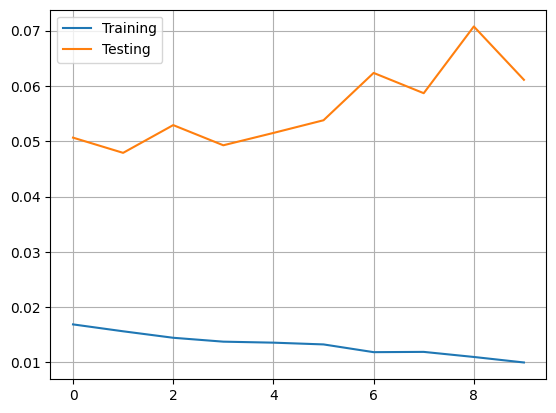

In [17]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix

pred = model.predict(X_test)
print('pred.shape = ', pred.shape)
pred = np.argmax(pred, axis=-1)
confusion_matrix(y_test, pred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
pred.shape =  (10000, 10)


array([[ 965,    1,    0,    1,    1,    0,   10,    2,    0,    0],
       [   0, 1130,    1,    0,    0,    0,    3,    1,    0,    0],
       [   0,    4, 1019,    0,    0,    0,    1,    7,    1,    0],
       [   1,    0,    1,  992,    0,   11,    0,    1,    2,    2],
       [   0,    0,    0,    0,  974,    0,    0,    1,    2,    5],
       [   1,    0,    0,    2,    0,  885,    2,    1,    0,    1],
       [   2,    2,    0,    0,    0,    4,  950,    0,    0,    0],
       [   0,    1,    4,    2,    1,    0,    0, 1018,    1,    1],
       [   2,    1,    3,    1,    0,    2,    4,    1,  958,    2],
       [   0,    0,    0,    1,    6,    7,    1,    6,    2,  986]],
      dtype=int64)